AAG Mar 2018

In [1]:
%matplotlib inline

import sys, os, copy, warnings, time
import qinfer as qi
import numpy as np
from scipy.optimize import curve_fit
from scipy.io import loadmat
from scipy.stats import iqr
import matplotlib.pyplot as plt
from matplotlib import cm

from IPython.display import display, Math, Latex

In [2]:
%run nv_sensing_lib.py

In [3]:
%run allmyfonts.py

Fonts loaded


# Export settings

In [4]:
dire = os.getcwd()
dire = dire+"/test_results/"+"/QHL_sensing_shotsweep"
#dire = os.path.join("..","Efficient sensing", "Figures", "Figures for paper")
dire = os.path.normpath(dire)
print('Files will be saved in:')
print(dire)

Files will be saved in:
C:\Local Documents\Dropbox (Qsim)\Progetti con esterni\Qinfer_Sensing\test_results\QHL_sensing_shotsweep


In [5]:
string_output = []
# move to True to save data and plots

In [7]:
enable_save = True
enable_data_save = False

# Initial import of data

In [8]:
directory = os.path.join("..","Efficient sensing", "Data from Ulm", "Data_Sweeps")
filename = "Ramsey1.mat"

In [9]:
newfilename = os.path.join(directory, filename)
print(os.path.abspath(newfilename))
#usecols only selects one normalisation 

Ramsey_data = loadmat(os.path.abspath(newfilename))

C:\Local Documents\Dropbox (Qsim)\Progetti con esterni\Efficient sensing\Data from Ulm\Data_Sweeps\Ramsey1.mat


In [10]:
normalize_all = Ramsey_data["normalize"]
signal_all = Ramsey_data["signal"]

len_datapoints = len(signal_all[0])
Ramsey_xdata = np.linspace(20, 10000, 500)/10**3

In [11]:
num_phot = np.mean( [np.sum(normalize_all[:,a])/len(normalize_all) for a in range(len(normalize_all[0])) ]  )
print("N_sweeps available:", len(signal_all))
print("N_phot estimate:", num_phot)

N_sweeps available: 20275
N_phot estimate: 0.151065647349


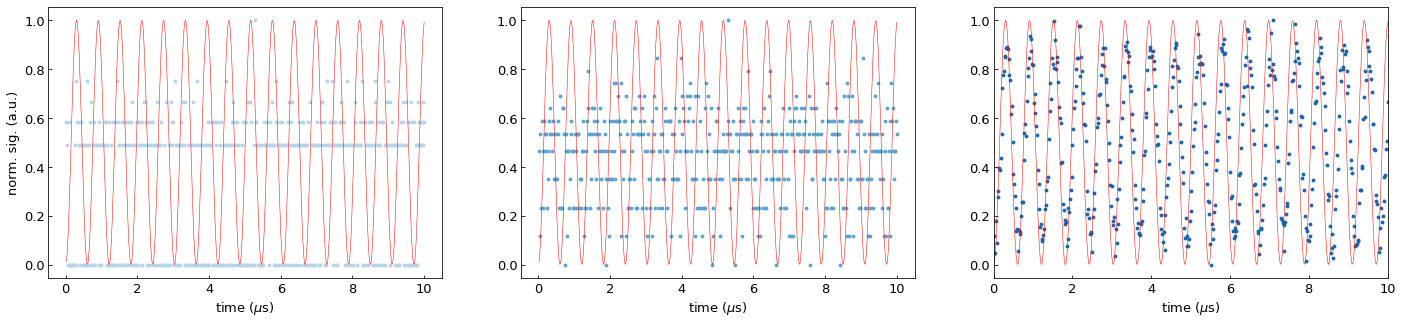

In [12]:
prelim_sweeps = [8, 32, len(signal_all)]
cm_subsection = np.linspace(0.3, 0.8, len(prelim_sweeps) ) 
colors = dict(zip(  prelim_sweeps, [cm.Blues(x) for x in cm_subsection] ))

f, axarr = plt.subplots(1,3, figsize=(5*3*1.6,5))

for idrun in range(len(prelim_sweeps)):

    signal_mean = np.mean(signal_all[0:prelim_sweeps[idrun]], axis = 0)
    normalize_mean = np.mean(normalize_all[0:prelim_sweeps[idrun]], axis = 0)
    normalize_mean = np.array([ max(normalize_mean[i], 1) for i in range(len_datapoints)])
    Ramsey_ydata = rescalefewdata(signal_mean/normalize_mean)

    axarr[idrun].scatter(Ramsey_xdata, Ramsey_ydata, color =  colors[ prelim_sweeps[idrun] ], s= 8)
    axarr[idrun].plot(Ramsey_xdata, DampedOscill(Ramsey_xdata, 1.647*2*PI, 0.0001), color =  'red', linewidth=0.5)
    
    axarr[idrun].set_xlabel(r'time ($\mu$s)', fontsize =axis_font["size"])
    
    
# plt.title('Rescaled Ramsey data')

axarr[0].set_ylabel('norm. sig. (a.u.)', fontsize = axis_font["size"] )
thisfile = "Compare_Ramsey_Fringe_Data.pdf"
plt.xlim(0,10)
# if enable_save: savefigs(dire, thisfile)

plt.show()

## FFT Analysis

In [13]:
list_sweeps = []
i = 0
while 2**i < len(signal_all):
    list_sweeps.append(2**i)
    i += 1
list_sweeps

[1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096, 8192, 16384]

In [14]:
fft_output = dict(zip( list_sweeps, [None for i in list_sweeps]  ))

for try_sweeps in list_sweeps:
    sampling_factor = 100 if try_sweeps>1024 else 1
    
    signal_mean = np.mean(signal_all[0:try_sweeps], axis = 0)
    normalize_mean = np.mean(normalize_all[0:try_sweeps], axis = 0)
    normalize_mean = np.array([ max(normalize_mean[i], 1) for i in range(len_datapoints)])
    Ramsey_ydata = rescalefewdata(signal_mean/normalize_mean)

    [ft_freq, spectrum, est_omega, xlimit, err_omega, norm_factor] = fft_prec([Ramsey_xdata, Ramsey_ydata],sampling_factor=sampling_factor)
    
    fft_output[try_sweeps] = [ft_freq, spectrum, est_omega, xlimit, err_omega, norm_factor]
    print("Trying {:d} sweeps".format(try_sweeps))
    print("Estimated frequency from FFT =  {:.4f} +/- {:.4f} MHz".format( est_omega/(2*PI), err_omega/2/PI) )
    print("Mean estimated B from FFT = {:.3f} +/- {:.3f} uT".format(radfreq_to_B( est_omega), radfreq_to_B(err_omega) ))

Trying 1 sweeps
Estimated frequency from FFT =  5.7000 +/- 101.0745 MHz
Mean estimated B from FFT = 203.392 +/- 3606.622 uT
Trying 2 sweeps
Estimated frequency from FFT =  2.4000 +/- 0.1162 MHz
Mean estimated B from FFT = 85.639 +/- 4.147 uT
Lorentzian fit failed
Trying 4 sweeps
Estimated frequency from FFT =  17.0000 +/- 0.1000 MHz
Mean estimated B from FFT = 606.608 +/- 3.568 uT
Trying 8 sweeps
Estimated frequency from FFT =  21.1000 +/- 0.1646 MHz
Mean estimated B from FFT = 752.907 +/- 5.874 uT
Trying 16 sweeps
Estimated frequency from FFT =  3.4000 +/- 0.1710 MHz
Mean estimated B from FFT = 121.322 +/- 6.102 uT
Trying 32 sweeps
Estimated frequency from FFT =  20.0000 +/- 0.1698 MHz
Mean estimated B from FFT = 713.656 +/- 6.058 uT
Trying 64 sweeps
Estimated frequency from FFT =  1.6000 +/- 0.0901 MHz
Mean estimated B from FFT = 57.092 +/- 3.216 uT
Trying 128 sweeps
Estimated frequency from FFT =  1.6000 +/- 0.0442 MHz
Mean estimated B from FFT = 57.092 +/- 1.575 uT
Trying 256 sweep

10.0530964915 0.00042620879573


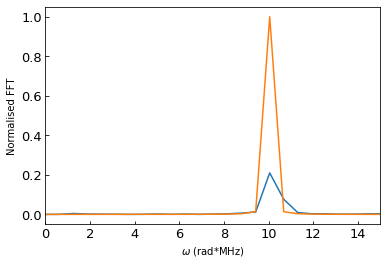

In [15]:
thissweep = 1024

sample_Lorentzian = dist_normalize(
        Lorentzian(fft_output[thissweep][0], fft_output[thissweep][2],  350*fft_output[thissweep][4], fft_output[thissweep][-1])
#         , method = "area", args = (fft_output[thissweep][0], fft_output[thissweep][2],  fft_output[thissweep][4], fft_output[thissweep][-1])  
    )/1

print(fft_output[thissweep][2],  fft_output[thissweep][4])

plt.plot(fft_output[thissweep][0], fft_output[thissweep][1])
plt.plot(fft_output[thissweep][0], sample_Lorentzian)

ylim = plt.ylim()
#plt.vlines(true_omega, *ylim, linestyles = 'dashed')
plt.ylim(*ylim)
plt.xlim(0., 15)
plt.xlabel('$\omega$ (rad*MHz)')
plt.ylabel('Normalised FFT')

## Good QML analysis

(with all experimental data obtained)

In [16]:
resample_thresh = 0.5
resample_a = 0.9

n_particles = 1000
n_experiments = 100

omegabounds = [0, 20]

In [17]:
signal_mean = np.mean(signal_all, axis = 0)
normalize_mean = np.mean(normalize_all, axis = 0)
normalize_mean = np.array([ max(normalize_mean[i], 1) for i in range(len_datapoints)])

Ramsey_ydata = rescalefewdata(signal_mean/normalize_mean)

run = DataPrecModel(freq_min=omegabounds[0], freq_max = omegabounds[1],  n_particles = n_particles)

In [18]:
good_output = run.est_prec(data = [Ramsey_xdata, Ramsey_ydata], resample_a = resample_a, resample_thresh = resample_thresh, 
                 n_experiments = n_experiments, verbose=False)

In [19]:
true_omega = 1.648*2*PI #np.array(good_output)[0,-1]
medsigma = np.array(good_output)[2,-1]

print("Mean estimated frequency = {:.3f} MHz \n\t +/- {:.3f} (median Bayesian credible interval)".format(true_omega/2/PI, medsigma/2/PI))

Mean estimated frequency = 1.648 MHz 
	 +/- 0.003 (median Bayesian credible interval)


## Multiple Runs

run for single shot -> full 20000, exp-scaling steps (10**x or 2**x) 
but at least 100 repeats/sweep

plot QL as function of # sweeps

### Import from old runs

In [20]:
#impfilename = dire + "\\Sweep_Nruns_1000_Nexp_150_alldata___2018-03-12_20.02.22.pk"
#impfilename = dire + "\\AdjustedSweep_Nruns_1000_Nexp_150_alldata___2018-04-17_14.40.55.pk"
# impfilename = dire + "\\AdaptSingleShotParam_Sweep_Nruns_1000_Nexp_150_alldata___2018-05-04_12.38.39.pk"
allfilenames = "Sweep_forSI_Nruns_1000_Nexp_500"

In [21]:
impfilename = dire + "\\AdaptSingleShotParam_Sweep_Nruns_1000_Nexp_500_alldata___2018-05-08_10.33.53.pk"
sweep_outputs = readdata(impfilename)
steps = range(len(sweep_outputs[list(sweep_outputs.keys())[0]]['acctimes']))

In [22]:
impfilename = dire + "\\AdjustedSweep_Nruns_1000_Nexp_150_alldata___2018-04-17_14.40.55.pk"
old_outputs = readdata(impfilename)
steps = range(len(sweep_outputs[list(sweep_outputs.keys())[0]]['acctimes']))

In [23]:
# check these data from the txt summary file
n_runs = 1000

convertms = 1/1000  # to convert in ms

timestamp = mytimestamp()

###  <font color='red'> Execute MAIN</font>

In [32]:
timestamp = mytimestamp()

convertms = 1/1000  # to convert in ms

list_n_particles = 25000/(np.log(list_sweeps)+1)
list_n_particles = np.array([int(n) for n in list_n_particles])

In [33]:
list_resample_thresh = [max(0.1, np.around(0.5 - 0.4/np.log(try_sweeps),3)) for try_sweeps in list_sweeps]
list_resample_a = np.around(np.linspace(0.98, 0.9, len(list_n_particles)),3)

C:\Anaconda\lib\site-packages\ipykernel\__main__.py:1: RuntimeWarning: divide by zero encountered in double_scalars
  if __name__ == '__main__':


In [34]:
for i in range(len(list_n_particles)):
    print(list_sweeps[i], list_n_particles[i], list_resample_thresh[i], list_resample_a[i])

1 25000 0.1 0.98
2 14765 0.1 0.974
4 10476 0.211 0.969
8 8118 0.308 0.963
16 6626 0.356 0.957
32 5598 0.385 0.951
64 4846 0.404 0.946
128 4272 0.418 0.94
256 3819 0.428 0.934
512 3453 0.436 0.929
1024 3152 0.442 0.923
2048 2898 0.448 0.917
4096 2683 0.452 0.911
8192 2497 0.456 0.906
16384 2335 0.459 0.9


###  <font color='red'> Start ALL RUNS </font>

In [35]:
string_output = []
sweep_outputs = dict(zip(list_sweeps, [None for i in list_sweeps]))

In [36]:
n_runs = 1000
n_experiments = 150

omegabounds = [0, 40]
exp_sim_ratio = n_runs/len(Ramsey_xdata)

In [ ]:
for idsweep in range(len(list_sweeps)):
    
    try_sweeps = list_sweeps[idsweep]
    string_output.append("Trial with sweeps = {:d} rad*MHz".format(try_sweeps))

    resample_thresh = list_resample_thresh[idsweep]
    resample_a = list_resample_a[idsweep]

    run = DataPrecModel(freq_min=omegabounds[0], freq_max = omegabounds[1],  n_particles = list_n_particles[idsweep])
    run.fft_est = 1.647*2*PI

    output = []

    start = time.time()

    signal_mean = np.mean(signal_all[0:try_sweeps], axis = 0)
    normalize_mean = np.mean(normalize_all[0:try_sweeps], axis = 0)
    normalize_mean = np.array([ max(normalize_mean[i], 1) for i in range(len_datapoints)])

    Ramsey_ydata = rescalefewdata(signal_mean/normalize_mean)

    for thisrun in range(n_runs):

        output.append(
            run.est_prec(data = [Ramsey_xdata, Ramsey_ydata], resample_a = resample_a, resample_thresh = resample_thresh, 
                         n_experiments = n_experiments, verbose=False)
              )
        
    npoutput=np.array([output])
    
    meanW = np.mean(npoutput[0,:,0], axis=0)
    estW = meanW[-1]
    medsigma = np.median(npoutput[0,:,2,-1], axis=0)
    
    medW = np.median(npoutput[0,:,0], axis=0)
    stdevW = np.std(npoutput[0,:,0], axis=0)
    iqrW = iqr(npoutput[0,:,0], axis=0, rng=(50-68.27/2, 50+68.27/2))
    
    string_output.append("Mean estimated frequency = {:.3f} rad*MHz".format(estW))
    string_output.append("Mean estimated frequency = {:.3f} MHz \n\t +/- {:.3f} (st.dev. from several runs) \n\t +/- {:.3f} (iqr from several runs) \n\t +/- {:.3f} (median Bayesian credible interval)".format(
            estW/2/PI, stdevW[-1]/2/PI, iqrW[-1]/2/PI, medsigma/2/PI))
    print(string_output[-1])
    string_output.append("Mean estimated B = {:.1f} uT \n\t +/- {:.3f} (``) \n\t +/- {:.3f} (``) \n\t +/- {:.3f} (``)".format(
            radfreq_to_B(estW),radfreq_to_B(stdevW[-1]),radfreq_to_B(iqrW[-1]),radfreq_to_B(medsigma)))
    print(string_output[-1])
        
    medcov = radfreq_to_B(np.median(npoutput[0,:,2], axis=0))
    errcov = radfreq_to_B(np.std(npoutput[0,:,2], axis=0))
    iqrcov = radfreq_to_B(iqr(npoutput[0,:,2], axis=0, rng=(50-68.27/2, 50+68.27/2)) )

    errcovsup = np.empty(len(iqrcov))
    errcovinf = np.empty(len(iqrcov))

    iqrcovsup = np.empty(len(iqrcov))
    iqrcovinf = np.empty(len(iqrcov))
    
    for i in range(len(iqrcov)):
        iqrcovinf[i] = radfreq_to_B( 
            iqr(npoutput[0,:,2,i][npoutput[0,:,2,i]<np.median(npoutput[0,:,2,i])], rng=(100-68.27, 100)) )
        iqrcovsup[i] = radfreq_to_B( 
            iqr(npoutput[0,:,2,i][npoutput[0,:,2,i]>np.median(npoutput[0,:,2,i])], rng=(0, 68.27)) )

    for i in range(len(errcov)):
        errcovinf[i] = radfreq_to_B( 
            np.std(npoutput[0,:,2,i][npoutput[0,:,2,i]<np.median(npoutput[0,:,2,i])]) )
        errcovsup[i] = radfreq_to_B( 
            np.std(npoutput[0,:,2,i][npoutput[0,:,2,i]>np.median(npoutput[0,:,2,i])]) )

    loglowbound = np.floor(np.log10(min(medcov)))
    
    acctimes = np.mean(npoutput[0,:,3], axis=0)*convertms
    print("Max accumulated time (ms): " + str(max(acctimes)) )
    
    popt, pcov = scaling_fit(scale_function, acctimes, medcov, errcov, skip_start=2)

    string_output.append("Scaling parameter for eta^2: {:.4f} +/- {:.4f}".format( popt[1], np.sqrt(pcov[1][1])  ))
    print(string_output[-1])
    
    n_bins = 10
    bins = [[ int(0+idx/n_bins*n_runs), int(0+(idx+1)/n_bins*n_runs-1) ] for idx in range(n_bins)]
    
    
    all_popt = []

    for runset in range(n_bins):

        part_medcov = radfreq_to_B(np.median(npoutput[0,bins[runset][0]:bins[runset][1],2], axis=0))
        part_errcov = radfreq_to_B(np.std(npoutput[0,bins[runset][0]:bins[runset][1],2], axis=0))
        part_acctimes = np.mean(npoutput[0,bins[runset][0]:bins[runset][1],3], axis=0)*convertms

        part_popt, part_pcov = scaling_fit(scale_function, part_acctimes, part_medcov, part_errcov, skip_start=2)

        all_popt.append(part_popt[1])
        
    meanQL = np.mean(npoutput[0,:,1], axis=0)
    medQL = np.median(npoutput[0,:,1], axis=0)
    errQL = np.std(npoutput[0,:,1], axis=0)
    iqrQL = iqr(npoutput[0,:,1], axis=0, rng=(50-68.27/2, 50+68.27/2)) 

    errQLsup = np.empty(len(errQL))
    errQLinf = np.empty(len(errQL))

    iqrQLsup = np.empty(len(iqrQL))
    iqrQLinf = np.empty(len(iqrQL))
    
    for i in range(len(iqrQL)):
        iqrQLinf[i] = iqr(npoutput[0,:,1,i][npoutput[0,:,1,i]<np.median(npoutput[0,:,1,i])], rng=(100-68.27, 100))
        iqrQLsup[i] = iqr(npoutput[0,:,1,i][npoutput[0,:,1,i]>np.median(npoutput[0,:,1,i])], rng=(0, 68.27)) 

    for i in range(len(errQL)):
        errQLinf[i] = np.std(npoutput[0,:,1,i][npoutput[0,:,1,i]<np.median(npoutput[0,:,1,i])]) 
        errQLsup[i] = np.std(npoutput[0,:,1,i][npoutput[0,:,1,i]>np.median(npoutput[0,:,1,i])]) 

    
    string_output.append("Mean final Q.L. = " + str( np.mean(npoutput[0,:,1,-1])) )  
    print(string_output[-1])
    string_output.append("Median final Q.L. = " +str(np.median(npoutput[0,:,1,-1])) )
    print(string_output[-1])
    
    sweep_outputs[try_sweeps] = {
        'estW' : meanW[-1], 
        'meanW' : meanW, 
        'medW' : medW, 
        'stdevW' :  stdevW,
        'iqrW' : iqrW,
        'medsigma': medsigma,
        'medcov': medcov,
        'errcov': errcov,
        'iqrcov' : iqrcov,
        'errcovinf': errcovinf,
        'errcovsup': errcovsup,
        'iqrcovinf': iqrcovinf,
        'iqrcovsup': iqrcovsup,
        'loglowbound': loglowbound,
        'acctimes': acctimes,
        'popt': popt,
        'pcov': pcov,
        'all_popt': all_popt,
        'meanQL': meanQL,
        'medQL': medQL,
        'errQL': errQL,
        'iqrQL' : iqrQL,
        'errQLinf': errQLinf,
        'errQLsup': errQLsup,
        'iqrQLinf': iqrQLinf,
        'iqrQLsup': iqrQLsup,
        
        
    }
    

    print("Done with sweeps = " + str(try_sweeps) + ", Elapsed time: " + str(time.time()-start) + " secs")

C:\Anaconda\lib\site-packages\qinfer\smc.py:285: ApproximationWarning: Extremely small n_ess encountered (7.459838413822376). Resampling is likely to fail. Consider adding particles, or resampling more often.
  ApproximationWarning


In [ ]:
allfilenames = "Sweep_" + "Nruns_"+str(n_runs)+"_Nexp_"+str(n_experiments)

steps = range(np.shape(npoutput)[3])

In [855]:
fileformat = '.pk'
thisfile = allfilenames+"_alldata__"+timestamp
if enable_data_save: savedata(dire, thisfile, sweep_outputs, fileformat)

C:\Users\ag15141\Local Documents\Cloud\Dropbox (Qsim)\Qinfer_Sensing\test_results\QHL_sensing_shotsweep\AdaptSingleShotParam_Sweep_Nruns_1000_Nexp_500_alldata___2018-05-08_10.33.53.pk


###  <font color='red'> Start SINGLE Execute </font>

In [663]:
%run nv_sensing_lib.py

In [664]:
n_runs = 1000
n_experiments = 500

omegabounds = [0, 40]
exp_sim_ratio = n_runs/len(Ramsey_xdata)

In [665]:
idsweep = 3

try_sweeps = list_sweeps[idsweep]
string_output.append("Trial with sweeps = {:d} rad*MHz".format(try_sweeps))

# good set of params: root = 5, 0.3, 0.95 OR root=1, 0.7, 0.99
resample_thresh = 0.7 #list_resample_thresh[idsweep]
resample_a = 0.99
n_particles = 15000


run = NoisyDataPrecModel(freq_min=omegabounds[0], freq_max = omegabounds[1],  n_particles = n_particles, 
                        noise = "Unbalanced", eta = 180/250)
run.fft_est = 1.647*2*PI

output = []

start = time.time()

signal_mean = np.mean(signal_all[0:try_sweeps], axis = 0)
normalize_mean = np.mean(normalize_all[0:try_sweeps], axis = 0)
normalize_mean = np.array([ max(normalize_mean[i], 1) for i in range(len_datapoints)])

Ramsey_ydata = rescalefewdata(signal_mean/normalize_mean)

for thisrun in range(n_runs):

    output.append(
        run.est_prec(data = [Ramsey_xdata, Ramsey_ydata],  n_shots = 1, n_experiments = n_experiments, 
                     resample_a = resample_a, resample_thresh = resample_thresh, 
                     use_heuristic = "rootPGH", heuristic_ratio = 1.0, heuristic_root = 1.,
                     verbose=False)
          )

npoutput=np.array([output])

meanW = np.mean(npoutput[0,:,0], axis=0)
estW = meanW[-1]
medsigma = np.median(npoutput[0,:,2,-1], axis=0)
meansigma = np.mean(npoutput[0,:,2,-1], axis=0)

medW = np.median(npoutput[0,:,0], axis=0)
stdevW = np.std(npoutput[0,:,0], axis=0)
iqrW = iqr(npoutput[0,:,0], axis=0, rng=(50-68.27/2, 50+68.27/2))

string_output.append("Mean estimated frequency = {:.3f} rad*MHz".format(estW))
string_output.append("Mean estimated frequency = {:.3f} MHz \n\t +/- {:.3f} (st.dev. from several runs) \n\t +/- {:.3f} (iqr from several runs) \n\t +/- {:.3f} (median Bayesian credible interval)".format(
        estW/2/PI, stdevW[-1]/2/PI, iqrW[-1]/2/PI, medsigma/2/PI))
print(string_output[-1])
string_output.append("Mean estimated B = {:.1f} uT \n\t +/- {:.3f} (``) \n\t +/- {:.3f} (``) \n\t +/- {:.3f} (``)".format(
        radfreq_to_B(estW),radfreq_to_B(stdevW[-1]),radfreq_to_B(iqrW[-1]),radfreq_to_B(medsigma)))
print(string_output[-1])

medcov = radfreq_to_B(np.median(npoutput[0,:,2], axis=0))
errcov = radfreq_to_B(np.std(npoutput[0,:,2], axis=0))
iqrcov = radfreq_to_B(iqr(npoutput[0,:,2], axis=0, rng=(50-68.27/2, 50+68.27/2)) )

errcovsup = np.empty(len(iqrcov))
errcovinf = np.empty(len(iqrcov))

iqrcovsup = np.empty(len(iqrcov))
iqrcovinf = np.empty(len(iqrcov))

for i in range(len(iqrcov)):
    iqrcovinf[i] = radfreq_to_B( 
        iqr(npoutput[0,:,2,i][npoutput[0,:,2,i]<np.median(npoutput[0,:,2,i])], rng=(100-68.27, 100)) )
    iqrcovsup[i] = radfreq_to_B( 
        iqr(npoutput[0,:,2,i][npoutput[0,:,2,i]>np.median(npoutput[0,:,2,i])], rng=(0, 68.27)) )

for i in range(len(errcov)):
    errcovinf[i] = radfreq_to_B( 
        np.std(npoutput[0,:,2,i][npoutput[0,:,2,i]<np.median(npoutput[0,:,2,i])]) )
    errcovsup[i] = radfreq_to_B( 
        np.std(npoutput[0,:,2,i][npoutput[0,:,2,i]>np.median(npoutput[0,:,2,i])]) )

loglowbound = np.floor(np.log10(min(medcov)))

acctimes = np.mean(npoutput[0,:,3], axis=0)*convertms
print("Max accumulated time (ms): " + str(max(acctimes)) )

popt, pcov = scaling_fit(scale_function, acctimes, medcov, errcov, skip_start=2)

string_output.append("Scaling parameter for eta^2: {:.4f} +/- {:.4f}".format( popt[1], np.sqrt(pcov[1][1])  ))
print(string_output[-1])

n_bins = 10
bins = [[ int(0+idx/n_bins*n_runs), int(0+(idx+1)/n_bins*n_runs-1) ] for idx in range(n_bins)]


all_popt = []

for runset in range(n_bins):

    part_medcov = radfreq_to_B(np.median(npoutput[0,bins[runset][0]:bins[runset][1],2], axis=0))
    part_errcov = radfreq_to_B(np.std(npoutput[0,bins[runset][0]:bins[runset][1],2], axis=0))
    part_acctimes = np.mean(npoutput[0,bins[runset][0]:bins[runset][1],3], axis=0)*convertms

    part_popt, part_pcov = scaling_fit(scale_function, part_acctimes, part_medcov, part_errcov, skip_start=2)

    all_popt.append(part_popt[1])

meanQL = np.mean(npoutput[0,:,1], axis=0)
medQL = np.median(npoutput[0,:,1], axis=0)
errQL = np.std(npoutput[0,:,1], axis=0)
iqrQL = iqr(npoutput[0,:,1], axis=0, rng=(50-68.27/2, 50+68.27/2)) 

errQLsup = np.empty(len(errQL))
errQLinf = np.empty(len(errQL))

iqrQLsup = np.empty(len(iqrQL))
iqrQLinf = np.empty(len(iqrQL))

for i in range(len(iqrQL)):
    iqrQLinf[i] = iqr(npoutput[0,:,1,i][npoutput[0,:,1,i]<np.median(npoutput[0,:,1,i])], rng=(100-68.27, 100))
    iqrQLsup[i] = iqr(npoutput[0,:,1,i][npoutput[0,:,1,i]>np.median(npoutput[0,:,1,i])], rng=(0, 68.27)) 

for i in range(len(errQL)):
    errQLinf[i] = np.std(npoutput[0,:,1,i][npoutput[0,:,1,i]<np.median(npoutput[0,:,1,i])]) 
    errQLsup[i] = np.std(npoutput[0,:,1,i][npoutput[0,:,1,i]>np.median(npoutput[0,:,1,i])]) 


string_output.append("Mean final Q.L. = " + str( np.mean(npoutput[0,:,1,-1])) )  
print(string_output[-1])
string_output.append("Median final Q.L. = " +str(np.median(npoutput[0,:,1,-1])) )
print(string_output[-1])

sweep_outputs[try_sweeps] = {
    'estW' : meanW[-1], 
    'meanW' : meanW, 
    'medW' : medW, 
    'stdevW' :  stdevW,
    'iqrW' : iqrW,
    'medsigma': medsigma,
    'meansigma': meansigma,
    'medcov': medcov,
    'errcov': errcov,
    'iqrcov' : iqrcov,
    'errcovinf': errcovinf,
    'errcovsup': errcovsup,
    'iqrcovinf': iqrcovinf,
    'iqrcovsup': iqrcovsup,
    'loglowbound': loglowbound,
    'acctimes': acctimes,
    'popt': popt,
    'pcov': pcov,
    'all_popt': all_popt,
    'meanQL': meanQL,
    'medQL': medQL,
    'errQL': errQL,
    'iqrQL' : iqrQL,
    'errQLinf': errQLinf,
    'errQLsup': errQLsup,
    'iqrQLinf': iqrQLinf,
    'iqrQLsup': iqrQLsup,


}


print("Done with sweeps = " + str(try_sweeps) + ", Elapsed time: " + str(time.time()-start) + " secs")

Mean estimated frequency = 1.763 MHz 
	 +/- 1.861 (st.dev. from several runs) 
	 +/- 4.500 (iqr from several runs) 
	 +/- 0.012 (median Bayesian credible interval)
Mean estimated B = 62.9 uT 
	 +/- 66.390 (``) 
	 +/- 160.556 (``) 
	 +/- 0.417 (``)
Max accumulated time (ms): 2.65766572
Scaling parameter for eta^2: -0.4327 +/- 0.0078
Mean final Q.L. = 137.191776417
Median final Q.L. = 88.196493717
Done with sweeps = 8, Elapsed time: 2573.136446237564 secs


In [28]:
npoutput=np.array([output])

n_bins = 10
bins = [[ int(0+idx/n_bins*n_runs), int(0+(idx+1)/n_bins*n_runs-1) ] for idx in range(n_bins)]

all_popt = []

for runset in range(n_bins):

    part_medcov = radfreq_to_B(np.median(npoutput[0,bins[runset][0]:bins[runset][1],2], axis=0))
    part_errcov = radfreq_to_B(np.std(npoutput[0,bins[runset][0]:bins[runset][1],2], axis=0))
    part_acctimes = np.mean(npoutput[0,bins[runset][0]:bins[runset][1],3], axis=0)*convertms

    part_popt, part_pcov = scaling_fit(scale_function, part_acctimes, part_medcov, part_errcov, skip_start=2)

    all_popt.append(part_popt[1])



sweep_outputs[8]["all_popt"] = all_popt

NameError: name 'output' is not defined

In [29]:
allfilenames = "AdaptSingleShotParam_Sweep_" + "Nruns_"+str(n_runs)+"_Nexp_"+str(n_experiments)

steps = range(np.shape(npoutput)[3])

NameError: name 'npoutput' is not defined

In [30]:
fileformat = '.pk'
thisfile = allfilenames+"_alldata__"+timestamp
if enable_data_save: savedata(dire, thisfile, sweep_outputs, fileformat)

## Analysis of data

In [26]:
enable_save = False
enable_data_save = False

In [27]:
all_sweeps = sorted(list(sweep_outputs.keys()))
print("Available sweep numbers: \n", all_sweeps  )

Available sweep numbers: 
 [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096, 8192, 16384]


In [28]:
all_sweeps = [8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096, 8192, 16384]

In [29]:
for thissweep in all_sweeps:
    print(thissweep, sweep_outputs[thissweep]["medW"][-1]/2/PI, radfreq_to_B(sweep_outputs[thissweep]["medsigma"]))

8 0.952434994991 0.416935944299
16 0.748564215604 0.433716475273
32 1.72907201805 0.461310375565
64 2.14971880034 0.454721089005
128 1.60401076213 0.313831675243
256 1.59927400845 0.18425585684
512 1.60130004293 0.156712845738
1024 1.60061769157 0.0972144532759
2048 1.6006997623 0.0844710269758
4096 1.64953591574 0.078940250272
8192 1.64951327105 0.0776535481335
16384 1.64947297205 0.0782344640341


### $\sigma$ analysis

In [31]:
all_sweeps

NameError: name 'all_sweeps' is not defined

In [31]:
try_sweeps = np.array([8]) #, 128, 2048, 16384])

cm_subsection = np.linspace(0, 0.8, len(try_sweeps) ) 
colors = dict(zip(  try_sweeps, [cm.plasma(x) for x in cm_subsection] ))

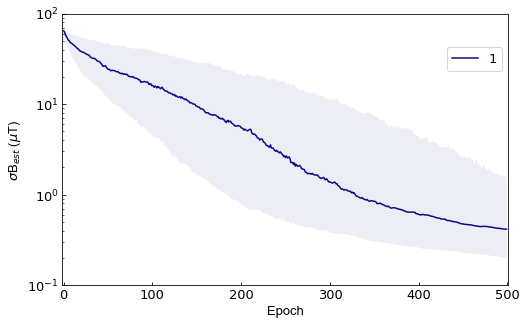

In [29]:
f, axarr = plt.subplots(figsize=(5*1.6,5))

for thissweep in try_sweeps:
    
    steps = range(len(sweep_outputs[thissweep]["acctimes"]))

    medcov = sweep_outputs[thissweep]["medcov"]
    iqrcovsup = sweep_outputs[thissweep]["iqrcovsup"]
    iqrcovinf = sweep_outputs[thissweep]["iqrcovinf"]
    loglowbound = sweep_outputs[thissweep]["loglowbound"]

    axarr.semilogy(medcov, color=colors[thissweep], label=str(int(num_phot*thissweep)))
    #replace errcov with iqrcov or [errcovsup, errcovinf], [iqrcovsup, iqrcovinf] here for different statistical analyses
    axarr.fill_between(steps, medcov+iqrcovsup, medcov-iqrcovinf,
        alpha=0.07, linewidth=0, facecolor=colors[thissweep], antialiased=True)


axarr.set_xlim(-2, max(steps)+2)
axarr.set_ylim(0.1, 100)

axarr.set_xlabel('Epoch', **axis_font)
axarr.set_ylabel('$\sigma$B$_{est}$ ($\mu$T)', **axis_font)

axarr.legend(bbox_to_anchor = (1,0.9), fontsize = 13)

thisfile = allfilenames+"_errB_"+"_SelSwp_"+str(list(try_sweeps))+timestamp+".pdf"
# if enable_save: savefigs(dire, thisfile)
thisfile = allfilenames+"_errB_"+"_SelSwp_"+str(list(try_sweeps))+timestamp+".png"
# if enable_save: savefigs(dire, thisfile)

plt.show()

### Compare with FFT

In [32]:
try_sweeps = np.array([8, 32, 1024, 16384])

cm_subsection = np.linspace(0, 0.8, len(try_sweeps) ) 
colors = dict(zip(  try_sweeps, [cm.plasma(x) for x in cm_subsection] ))

In [33]:
true_omega = 1.648

markers = []
plotbound = (0.,22)
subplotbound = (1.4,2.)

In [34]:
sweep_outputs[8]["medsigma"]

0.073415908618362447

In [35]:
B_to_radfreq( sweep_outputs[8]["medcov"][-350] )

1.6699502384887981

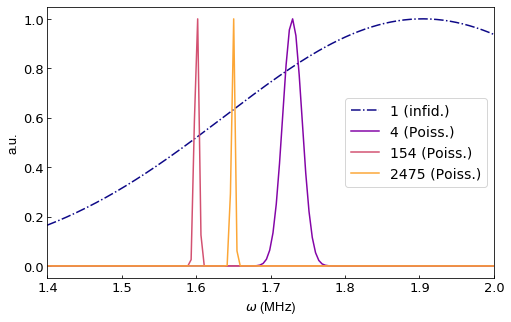

In [37]:
ft_freq = np.linspace(plotbound[0], plotbound[1] , 5000)

f, axarr = plt.subplots(figsize=(5*1.6,5))

for thissweep in try_sweeps:

    if thissweep == 8:
        estW = sweep_outputs[thissweep]["meanW"][-350]
#         medsigma = sweep_outputs[thissweep]["meansigma"]
        medsigma = B_to_radfreq( sweep_outputs[thissweep]["medcov"][-350] )
        mystyle = "-."
        mylabel = str(int(num_phot*thissweep)) + " (infid.)"
    else:
        estW = sweep_outputs[thissweep]["medW"][-1]
        medsigma = sweep_outputs[thissweep]["medsigma"]
        mystyle = "-"
        mylabel = str(int(num_phot*thissweep)) + " (Poiss.)"
    
#     print(fft_output[thissweep][2]/2/PI,  fft_output[thissweep][4]/2/PI)
    
    this_ffterr = max(fft_output[thissweep][4]/2/PI, 0.02)
    sample_Lorentzian = dist_normalize(
        Lorentzian(ft_freq, fft_output[thissweep][2]/2/PI,  this_ffterr, fft_output[thissweep][-1])
#         , method = "area", args = (ft_freq, fft_output[thissweep][2]/2/PI,  fft_output[thissweep][4]/2/PI, fft_output[thissweep][-1])  
    )
    sample_Gaussian = dist_normalize(
        Gaussian(ft_freq, estW/2/PI,  medsigma/2/PI)
#         , method = "area", args = (ft_freq, estW/2/PI,  medsigma/2/PI)
    )
    
#     axarr.plot(ft_freq, sample_Lorentzian, color = colors[thissweep], linestyle = "-.")
    axarr.plot(ft_freq, sample_Gaussian, color = colors[thissweep], linestyle = mystyle, label = mylabel)
    
#     markers.append(plt.Line2D((0,1),(0,0), color=colors[thissweep], marker='s', linestyle = mystyle))
#     markers.append(plt.Line2D((0,1),(0,0), color=colors[thissweep], marker='', linestyle = mystyle))

# markers.append(plt.Line2D((0,1),(0,0), color='k', linestyle='-.'))
# markers.append(plt.Line2D((0,1),(0,0), color='k', linestyle = '-'))


ylim = plt.ylim()

# axarr.vlines(true_omega, *ylim, linestyles = 'dashed')

plt.ylim(*ylim)
axarr.set_xlim(subplotbound[0], subplotbound[1])   #

axarr.set_xlabel('$\omega$ (MHz)', **axis_font)
axarr.set_ylabel('a.u.', **axis_font)

# axarr.legend(markers, [int(num_phot*try_sweep) for try_sweep in try_sweeps], # +['Infid.', 'Poiss.'],
#          loc='center right', fontsize = 14)
axarr.legend(loc='center right', fontsize = 14)

thisfile = allfilenames+"_FFTcompare_"+"_SelSwp_"+str(try_sweeps)+timestamp+".pdf"
# if enable_save: savefigs(dire, thisfile)
thisfile = allfilenames+"_FFTcompare_"+"_SelSwp_"+str(try_sweeps)+timestamp+".png"
# if enable_save: savefigs(dire, thisfile)

### Scaling Analysis

In [36]:
try_sweeps = [8, 32, 256, 2048, 16384]

guess_sweeptime = (3+1+0.02+0.05)*10**-3 #(in ms)

# • a laser pulse for initialization and readout (here 3 us, possible 1.5µs, minimal possible around 0.5µs)
# • a waiting time for relaxation (here 1µs)
# • a short TTL pulse for the photo detector (here 20ns) and 
# • the two pi/2-MW-pulses (here around 50ns together)

In [37]:
cm_subsection = [0.8]
cm_subsection.extend( np.linspace(0.5, 0., len(try_sweeps)-1 ) )
colors = dict(zip(  try_sweeps, [cm.plasma(x) for x in cm_subsection] ))

In [38]:
# positions = [(8*10**3, 0.01), (300,150), (10**6, 0.05), (8000, 7000)]
positions = [(7*10**5, convertms/100), (50, convertms *80), (50, convertms *320), (50, convertms *1280), (50, convertms *5120)]
pos_dict = dict(zip(try_sweeps, positions))

In [56]:
all_sweeps

[8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096, 8192, 16384]

8 last acctime 16.2500976657  final prec 0.00282484517956
32 last acctime 19.4063810604  final prec 0.0041298188305
256 last acctime 155.246960056  final prec 0.00527066856926
2048 last acctime 1241.96983345  final prec 0.00886189491375
16384 last acctime 9935.75033226  final prec 0.0608130650956
C:\Users\ag15141\Local Documents\Cloud\Dropbox (Qsim)\Qinfer_Sensing\test_results\QHL_sensing_shotsweep\Sweep_forSI_Nruns_1000_Nexp_500_etascaling__SelSwp_[8, 32, 256, 2048, 16384]_2018-07-02_10.30.35.pdf


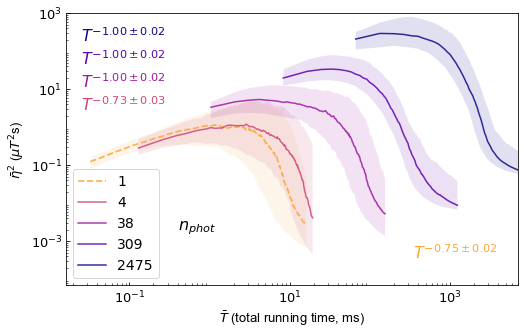

In [48]:
fig, spl = plt.subplots(figsize=(5*1.62,5))

low_plotlim = 10**-3

for thissweep in try_sweeps:
    
    steps = range(len(sweep_outputs[thissweep]["acctimes"]))
    
    acctimes = sweep_outputs[thissweep]["acctimes"] * convertms + 
                guess_sweeptime*thissweep*np.array(steps)
    medcov = sweep_outputs[thissweep]["medcov"]
    errcov = sweep_outputs[thissweep]["errcov"]
    iqrcovsup = sweep_outputs[thissweep]["iqrcovsup"]
    iqrcovinf = sweep_outputs[thissweep]["iqrcovinf"]
    
        
    medprec = convertms * np.array(acctimes * (medcov)**2)  # all the convertms are now here to convert in s for the precision units
    
    precsup = convertms * np.array(acctimes * (medcov+iqrcovsup)**2)
    precinf = convertms * np.array([max( acctimes[i] * (medcov[i]-iqrcovinf[i])**2, low_plotlim ) for i in steps])
    
    all_popt = sweep_outputs[thissweep]["all_popt"]
    
    adapt_skip = 10 if thissweep is 8 else 5
    
    shift_popt, shift_pcov = scaling_fit(scale_function, acctimes, 
                                         medprec, #guess_sweeptime*thissweep*np.array(steps), 
                                         errcov, #guess_sweeptime*thissweep*np.array(steps), 
                                         skip_start=adapt_skip)
    
    if thissweep is 8: 
        printaxis = 1
        linestyle = '--' 
        linewidth = 1.7
        trans = 0.1
        
        arrange_acctimes = np.logspace(np.log10(acctimes[1]), np.log10(acctimes[-1]), len(acctimes)-1)
        arrange_medprec = np.interp(arrange_acctimes, acctimes[1:], medprec[1:])
        spl.loglog(arrange_acctimes, arrange_medprec, 
                   color=colors[thissweep], linestyle = linestyle, linewidth =linewidth,
                     alpha=0.85,label=str(int(num_phot*thissweep))   )
        
    else:
        printaxis = 0
        linestyle = '-' 
        linewidth = 1.5
        trans = 0.12
        
        spl.loglog(acctimes[1:], medprec[1:], color=colors[thissweep], linestyle = linestyle, linewidth =linewidth,
             alpha=0.85,label=str(int(num_phot*thissweep))   )
    
    print(thissweep, "last acctime", acctimes[-1], " final prec", medprec[-1])
    
    
    
    delta = medprec[-1]/[scale_function(acctime, shift_popt[0], shift_popt[1]) 
                                     for acctime in acctimes ][-1]

#     spl[0].plot(acctimes[1:], np.array([scale_function(acctime, shift_popt[0], shift_popt[1]) 
#                                      for acctime in acctimes ])[1:]*delta*( (try_sweeps.index(thissweep))**3+2) , 
#              '--', color = colors[thissweep], linewidth=2.0)

    scale_err = np.std(all_popt)  #from estimated variability of the runs

    value = "$T^{{{:.2f} \pm {:.2f}}}$".format(shift_popt[1], scale_err)

#     positionx = (try_sweeps.index(thissweep)+2.)**5.3
#     positiony = (try_sweeps.index(thissweep)+0.9)**6.5
    (positionx, positiony) = pos_dict[thissweep]

    spl.fill_between(acctimes[1:], precsup[1:], precinf[1:],
        alpha=trans, linewidth=0, facecolor=colors[thissweep], antialiased=True)

    spl.text(0.0005*positionx, 35*positiony, value, fontdict={'color': colors[thissweep], 
                                                                 'style': 'normal', 'fontsize': 16} )

spl.text(0.02*20, convertms*2, r'$n_{phot}$', fontdict={'color': 'black', 'style': 'normal', 'fontsize': 16} )
    
# spl.set_yscale("log")
# spl.set_xscale("log")
# spl[1].set_yscale("log")
# spl[1].set_xscale("log")

# spl[0].axis((   min(sweep_outputs[1]["acctimes"]), max(sweep_outputs[16384]["acctimes"]), 
#              10**-2, 10**6   ))

[tick.label.set_fontsize(13)  for tick in spl.xaxis.get_major_ticks()]      
spl.set_xlabel(r'$\bar{T}$ (total running time, ms)',  **axis_font)
[tick.label.set_fontsize(13)  for tick in spl.yaxis.get_major_ticks()]  
spl.set_ylabel(r'$\bar{\eta}^2$ ($\mu T^2 $s)', **axis_font)  
spl.legend(loc= "lower left", fontsize=14  )

spl.set_xticks(spl.get_xticks()[::2])
spl.set_yticks(spl.get_yticks()[::2])

spl.set_xlim( 16*10**-3, 7*10**3 )
spl.set_ylim( convertms * 7*10**-2, 10**3 )

# spl[1].set_yticks(spl[1].get_yticks()[::2])
# spl[1].set_xlim( 16*10**-3, 1.4*10**1 )
# spl[1].set_ylim( 8*10**-2, 10**4 )
# spl[1].legend(loc= "lower left", fontsize=14  )
enable_save = True
thisfile = allfilenames+"_etascaling_"+"_SelSwp_"+str(try_sweeps)+timestamp+".pdf"
if enable_save: savefigs(dire, thisfile)
thisfile = allfilenames+"_etascaling_"+"_SelSwp_"+str(try_sweeps)+timestamp+".png"
# if enable_save: savefigs(dire, thisfile)

plt.show()

### Quadratic Losses

In [30]:
try_sweeps = [8] #, 128, 1024, 16384]

cm_subsection = np.linspace(0, 0.2, 2 ) 
colors = [cm.plasma(x) for x in cm_subsection]

In [31]:
true_omega = 1.648

In [32]:
W = sweep_outputs[thissweep]["meanW"]/2/PI
W[-1]

1.7630280139014614

C:\Users\ag15141\Local Documents\Cloud\Dropbox (Qsim)\Qinfer_Sensing\test_results\QHL_sensing_shotsweep\Sweep_forSI_Nruns_1000_Nexp_500_West__SelSwp_[8]_2018-05-09_19.56.26.pdf


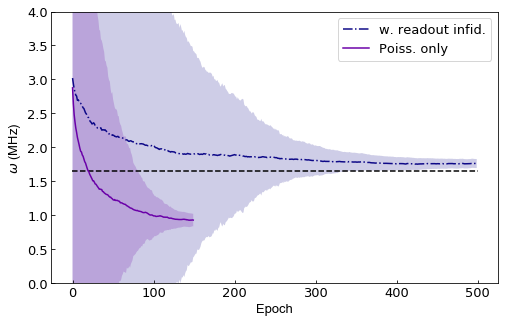

In [75]:
plt.figure(figsize=(5*1.6,5))

for thissweep in try_sweeps:

    W = sweep_outputs[thissweep]["meanW"]/2/PI
    mysteps = range(len(W))
    sig = sweep_outputs[thissweep]["medcov"]/2/PI
    
    plt.fill_between(mysteps, W+sig, [max(0, W[i]-sig[i]) for i in range(len(W))],
        alpha=0.2, linewidth=0, color=colors[0], antialiased=True)
    plt.plot(mysteps, W, color=colors[0],  label= "w. readout infid." , linestyle = '-.'   )
    
    bW = old_outputs[thissweep]["meanW"]/2/PI
    mysteps = range(len(bW))
    sig = old_outputs[thissweep]["medcov"]/2/PI
    
    plt.plot(bW, color=colors[1], label= "Poiss. only" )
    plt.fill_between(mysteps, bW+sig, [max(0, bW[i]-sig[i]) for i in range(len(bW))],
        alpha=0.2, linewidth=0, color=colors[1] , antialiased=True)

plt.xlabel('Epoch', **axis_font)
plt.ylabel(r'$\omega$ (MHz)', **axis_font)
plt.legend(fontsize = 13)

plt.hlines(true_omega, -1, len(W), linestyles = 'dashed')

plt.ylim(0, 4)

thisfile = allfilenames+"_West_"+"_SelSwp_"+str(try_sweeps)+timestamp+".pdf"
if enable_save: savefigs(dire, thisfile)
thisfile = allfilenames+"_West_"+"_SelSwp_"+str(try_sweeps)+timestamp+".png"
# if enable_save: savefigs(dire, thisfile)

plt.show()

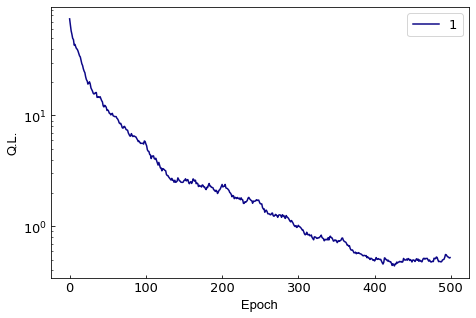

In [853]:
plt.figure(figsize=(5*1.5,5))

for thissweep in try_sweeps:

    QL = (2*PI*true_omega - sweep_outputs[thissweep]["meanW"])**2
#     QL = sweep_outputs[thissweep]["medQL"]
    QLsup = sweep_outputs[thissweep]["iqrQLsup"]
    QLinf = sweep_outputs[thissweep]["iqrQLinf"]

    loglowbound = np.floor(np.log10(min(QL)))

    plt.semilogy(QL, color=colors[thissweep], label=str(int(num_phot*thissweep))  )
#     plt.fill_between(steps, QL+QLsup, [max(QL[i]-QLinf[i], 10**loglowbound) for i in steps],
#     alpha=0.1, linewidth=0, facecolor=colors[thissweep], antialiased=True)

plt.xlabel('Epoch', **axis_font)
plt.ylabel('Q.L.', **axis_font)
plt.legend(fontsize = 13)

thisfile = allfilenames+"_QL_"+"_SelSwp_"+str(try_sweeps)+timestamp+".pdf"
# if enable_save: savefigs(dire, thisfile)
thisfile = allfilenames+"_QL_"+"_SelSwp_"+str(try_sweeps)+timestamp+".png"
# if enable_save: savefigs(dire, thisfile)

plt.show()

In [23]:
def time_analysis(npoutput, out_index, convert_factor = 1., plot_color=None, plot_title="", 
                    enable_save=False, todir=None, tofile = None):
    all_pgh_times =  []
    
    for particle in range(len(npoutput[0,:])):
        all_pgh_times.extend(npoutput[0,particle,out_index,:].tolist())
        
    medtimes = np.mean(npoutput[0,:,out_index,-1])*convert_factor
    print("Last (average) selected time ms: " + str(medtimes) )
    
    #plt.figure(figsize=(300, 300))
    
#     plt.grid(True)
    
    MIN, MAX = min(all_pgh_times), max(all_pgh_times)
    
    plt.hist(np.array(all_pgh_times), log=True, bins = 10 ** np.linspace(np.log10(MIN), np.log10(MAX), 50) ,
        color = plot_color, edgecolor='black')

    plt.xlabel(r'Times $\tau$ ($\mu$s)')
    plt.ylabel('Occurrences')
    
    plt.title(plot_title)
    plt.gca().set_xscale("log")
    
    if enable_save: 
        if todir is None or tofile is None:
            Exception("A file and path are needed to enable saving")
        else:
            savefigs(todir, tofile)
    
    plt.show()

    return [ np.array(all_pgh_times)*convert_factor, medtimes ]

'C:\\Users\\ag15141\\Local Documents\\Cloud\\Dropbox (Qsim)\\Qinfer_Sensing\\test_results\\QHL_sensing_shotsweep'

In [28]:
sweep_id = 8
myoutput = sweep_outputs[sweep_id]

[ all_pgh_times, medtimes] = time_analysis(myoutput, 5, convert_factor = convertms, 
                                           plot_color = colors[sweep_id], plot_title = 'Experiments available',
                                          enable_save = False, todir = dire, tofile = 'ExpTimesChoice_M'+str(sweep_id)+'.pdf')

TypeError: unhashable type: 'slice'

In [64]:
all_finprecs=[]
all_errprecs=[]

for thissweep in all_sweeps: 
    
    steps = range(len(sweep_outputs[thissweep]["acctimes"]))
    if thissweep == 16:
        acctime = sweep_outputs[thissweep]["acctimes"][-1] * convertms + guess_sweeptime*thissweep*2*max(steps)
    else:
        acctime = sweep_outputs[thissweep]["acctimes"][-1] * convertms + guess_sweeptime*thissweep*max(steps)
    medcov = sweep_outputs[thissweep]["medcov"][-1]
    medprec = convertms * (acctime * (medcov)**2)
    
    all_finprecs.append( medprec )
    
    
    # all_finprecs.append( convertms * acctime * (sweep_outputs[thissweep]["medcov"][-1])**2 )
    all_errprecs.append( 
                [convertms * acctime * 
                 (sweep_outputs[thissweep]["medcov"][-1]-sweep_outputs[thissweep]["iqrcovinf"][-1])**2, 
                 convertms* acctime * 
                 (sweep_outputs[thissweep]["medcov"][-1]+sweep_outputs[thissweep]["iqrcovsup"][-1])**2 ])    

all_errprecs = np.array(all_errprecs)
precweights = [np.abs(all_errprecs[i][0] + all_errprecs[i][1]) for i in range(len(all_errprecs))]

prec0 = [num_phot*np.array(all_sweeps)[1]*all_finprecs[1], 1, all_finprecs[-1]]

sweepopt, sweepcov = curve_fit(sweepscale_function, num_phot*np.array(all_sweeps), all_finprecs, p0 = prec0, sigma = precweights)


C:\Users\ag15141\Local Documents\Cloud\Dropbox (Qsim)\Qinfer_Sensing\test_results\QHL_sensing_shotsweep\Sweep_forSI_Nruns_1000_Nexp_500_etascaling__EXP_SelSwpJoint_[8, 32, 256, 2048, 16384]_2018-07-02_10.30.35.pdf


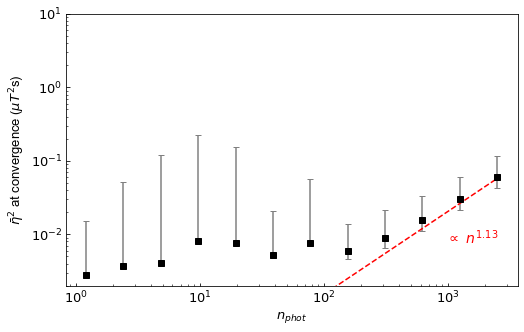

In [95]:
fig, spl = plt.subplots(figsize=(5*1.62, 5))

spl.errorbar(num_phot*np.array(all_sweeps), all_finprecs, yerr= np.array(all_errprecs).T/3,
                  linestyle= '', capsize=3, marker = 's' , color= 'black', ecolor= 'gray')  

sweepopt[2]=0
spl.plot(num_phot*np.array(all_sweeps), sweepscale_function(num_phot*np.array(all_sweeps), *sweepopt),
                  linestyle= '--', color= 'red')   

spl.set_xlabel('$n_{phot}$', **axis_font)
spl.set_ylabel(r'$ \bar{\eta}^2$ at convergence ($\mu T^2 $s)', **axis_font)  
[tick.label.set_fontsize(13)  for tick in spl.xaxis.get_major_ticks()]      
[tick.label.set_fontsize(13)  for tick in spl.yaxis.get_major_ticks()]      

spl.text(num_phot*np.array(all_sweeps)[7]+800, all_finprecs[0]*3-convertms, "$\propto$ $n^{{{:.2f}}}$".format(*[sweepopt[1]]) ,
           color = "red", fontsize= 14)  #"${:.4f}$ $n^{{{:.2f}}} + {:.3f}$"

spl.set_xscale("log")
spl.set_yscale("log")

#spl.set_ylim(-0.001, 0.1)
spl.set_ylim(0.002, 10)

# spl.ticklabel_format(axis='y', style='sci', scilimits=(0,0) )

thisfile = allfilenames+"_etascaling_"+"_EXP_SelSwpJoint_"+str(try_sweeps)+timestamp+".pdf"

if enable_save: savefigs(dire, thisfile)